In [1]:
from disk_utils_jax import jax_model, jax_model_all_1d
from regression import log_likelihood_1d_pos_spline, log_likelihood_1d_pos_all_pars_spline
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from datetime import datetime
from jax import jit
import numpy as np


In [2]:
disk_params = {}
disk_params['inclination'] = 40. #In degrees
disk_params['position_angle'] = 30. #In Degrees
disk_params['alpha_in'] = 5. #The inner power law
disk_params['alpha_out'] = -7. #The outer power law
disk_params['flux_scaling'] = 1e6

#The disk size
disk_params['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [3]:
spf_params = {'g1': 0.9, 'g2': 0.4, 'weight': 0.6}

disk_image = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params, spf_params)

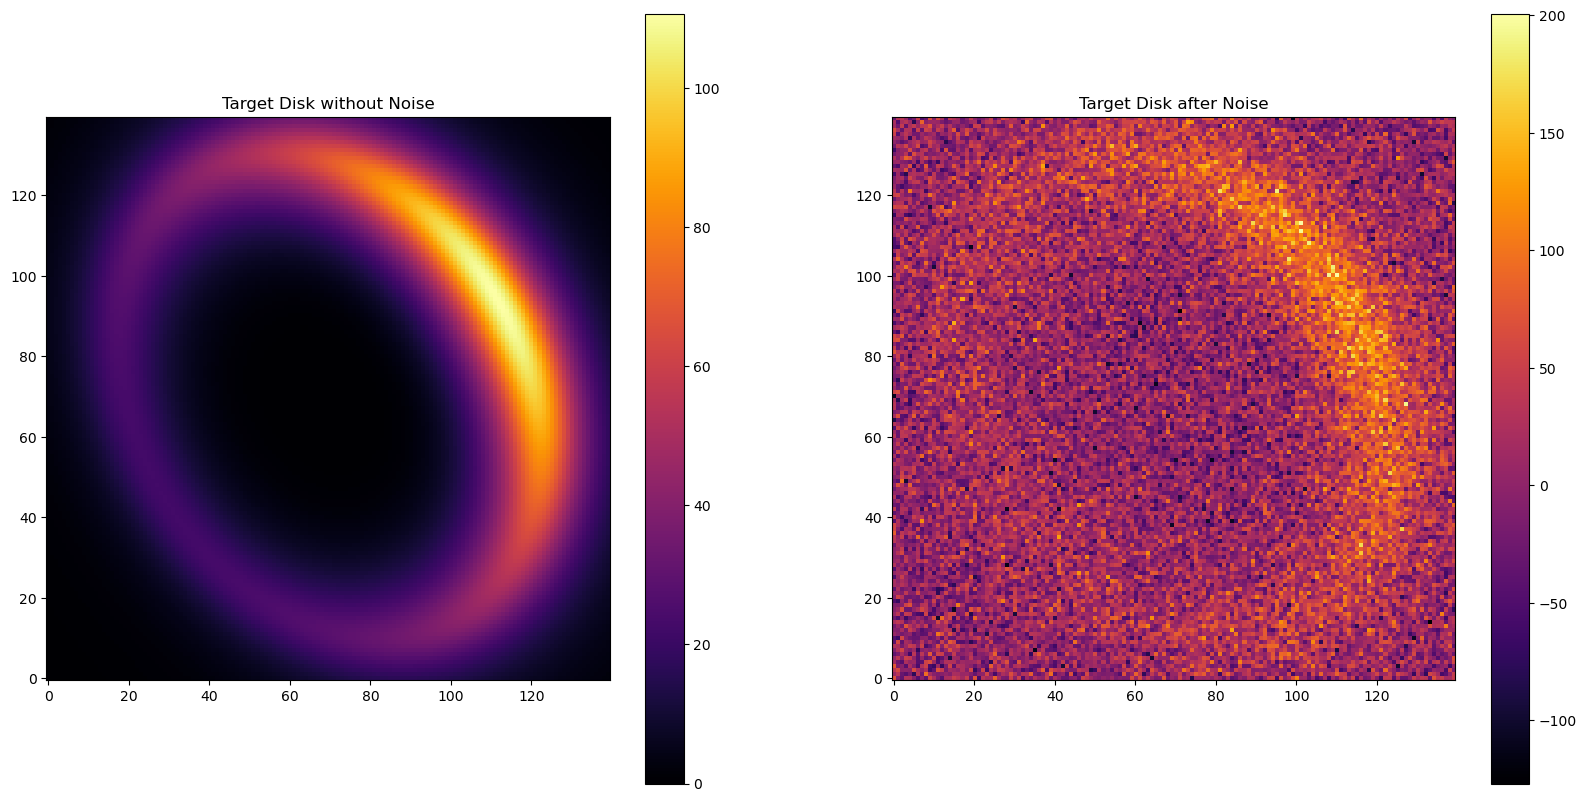

In [4]:
noise_level = 35
noise = np.random.normal(0, noise_level, disk_image.shape)

# Target Image
target_image = disk_image + noise

fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image, origin='lower', cmap='inferno')
axes[0].set_title("Target Disk without Noise")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(target_image, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk after Noise")
plt.colorbar(im,ax=axes[1])

### Just simulating the spline parameters

In [5]:
from scipy.optimize import minimize

In [6]:
# Initial Guess

init_params = {}
init_params['inclination'] = 45. #In degrees
init_params['position_angle'] = 45. #In Degrees
init_params['alpha_in'] = 5. #The inner power law
init_params['alpha_out'] = -5. #The outer power law
init_params['flux_scaling'] = 1e6
init_params['sma'] = 25.

init_disk_params = jnp.array([init_params['alpha_in'], init_params['alpha_out'], init_params['sma'], init_params['inclination'],
                           init_params['position_angle']])

In [7]:
KNOTS = 10

init_knot_xs = jnp.linspace(1, -1, KNOTS)
init_spf_params = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(DoubleHenyeyGreenstein_SPF.pack_pars({'g1': 0.5, 'g2': 0.5, 'weight': 0.7}), init_knot_xs)
all_pars_spline = jnp.concatenate([init_disk_params, init_spf_params])

init_image = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, init_params, init_spf_params)

# Creating error map
err_map = jnp.ones(target_image.shape)*noise_level

# Spline spf function (should work for all disk images)
llp_spline = lambda x: log_likelihood_1d_pos_all_pars_spline(x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                                                        disk_params['flux_scaling'], target_image, err_map)

# Using values from previous code block as initial guesses
opt = {'disp':True,'maxiter':1000}
soln_spline = minimize(llp_spline, all_pars_spline, options=opt, method = "Nelder-Mead")
print(soln_spline)

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 79778.765625
             x: [ 6.037e+00 -6.263e+00 ...  3.691e-02  1.864e-02]
           nit: 1000
          nfev: 1328
 final_simplex: (array([[ 6.037e+00, -6.263e+00, ...,  3.691e-02,
                         1.864e-02],
                       [ 6.038e+00, -6.297e+00, ...,  3.669e-02,
                         1.923e-02],
                       ...,
                       [ 6.070e+00, -6.084e+00, ...,  3.744e-02,
                         1.886e-02],
                       [ 6.061e+00, -6.179e+00, ...,  3.693e-02,
                         1.910e-02]], dtype=float32), array([ 7.978e+04,  7.978e+04, ...,  7.978e+04,  7.978e+04]))


/tmp/ipykernel_1518987/1703563287.py:18: RuntimeWarning: Maximum number of iterations has been exceeded.
  soln_spline = minimize(llp_spline, all_pars_spline, options=opt, method = "Nelder-Mead")


Text(0.5, 1.0, 'Target Image')

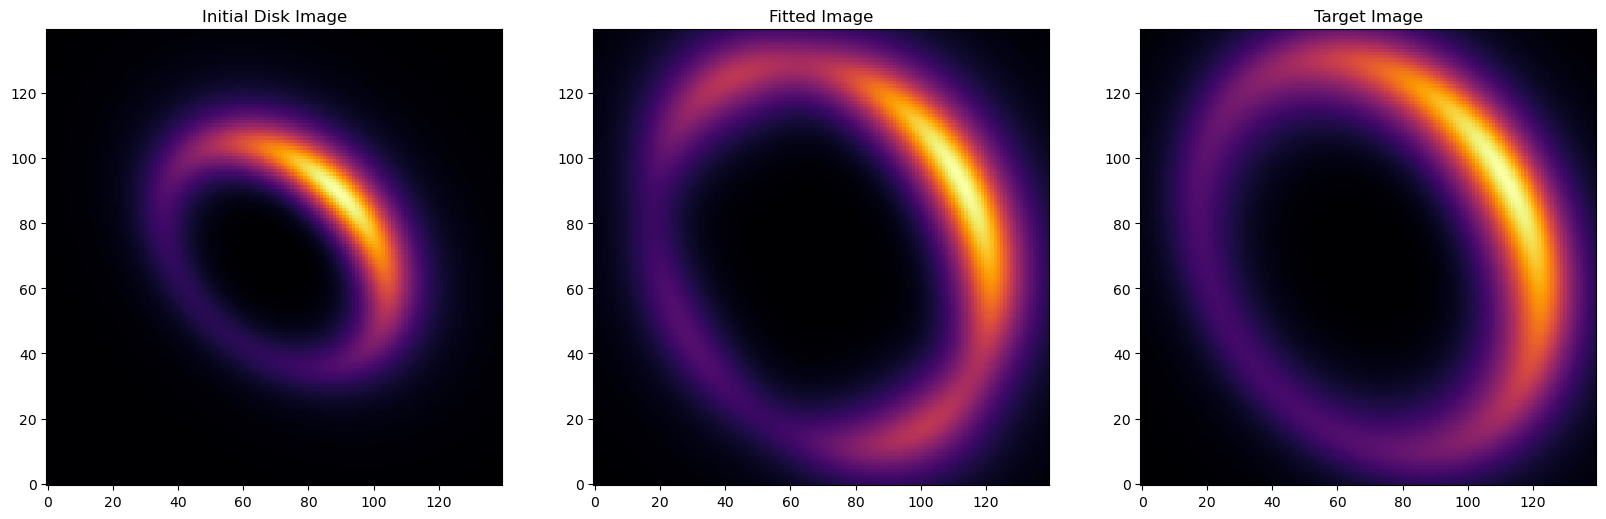

In [8]:
fitted_disk_image = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, soln_spline.x[0:5],
                                     InterpolatedUnivariateSpline_SPF.pack_pars(soln_spline.x[5:]), init_params["flux_scaling"])

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(init_image, origin='lower', cmap='inferno')
axes[0].set_title("Initial Disk Image")

im = axes[1].imshow(fitted_disk_image, origin='lower', cmap='inferno')
axes[1].set_title("Fitted Image")

im = axes[2].imshow(disk_image, origin='lower', cmap='inferno')
axes[2].set_title("Target Image")

In [9]:
fitted_disk_params = soln_spline.x[0:5]

'''
def run_sim(num_sims):
    vals = np.ndarray((KNOTS, num_sims))
    results = np.ndarray(num_sims)

    BOUNDS = np.array((np.zeros(KNOTS), np.ones(KNOTS)))

    for i in range(0, num_sims):
        array = np.random.uniform(BOUNDS[0], BOUNDS[1])
        ll = log_likelihood_1d_pos_spline(fitted_disk_params, array, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, init_params['flux_scaling'],
                                        target_image, err_map)
        vals = np.insert(vals, i, array, axis=1)
        results[i] = ll

    return results

start = datetime.now()
results1 = run_sim(1000)
end = datetime.now()
print(end-start)

start = datetime.now()
results2 = run_sim(10000)
end = datetime.now()
print(end-start)'''

"\ndef run_sim(num_sims):\n    vals = np.ndarray((KNOTS, num_sims))\n    results = np.ndarray(num_sims)\n\n    BOUNDS = np.array((np.zeros(KNOTS), np.ones(KNOTS)))\n\n    for i in range(0, num_sims):\n        array = np.random.uniform(BOUNDS[0], BOUNDS[1])\n        ll = log_likelihood_1d_pos_spline(fitted_disk_params, array, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, init_params['flux_scaling'],\n                                        target_image, err_map)\n        vals = np.insert(vals, i, array, axis=1)\n        results[i] = ll\n\n    return results\n\nstart = datetime.now()\nresults1 = run_sim(1000)\nend = datetime.now()\nprint(end-start)\n\nstart = datetime.now()\nresults2 = run_sim(10000)\nend = datetime.now()\nprint(end-start)"

In [10]:
'''import matplotlib.patches as mpatches

fig, axes = plt.subplots(1,2, figsize=(20,10))

# Creating legend with color box 
blue_patch = mpatches.Patch(color='skyblue', label='# of results')
red_patch = mpatches.Patch(color='red', label='Optimizer Log-Likelihood: '+str(round(soln_spline.fun, 2)))

axes[0].hist(results1, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title("1000 Simulations")
axes[0].vlines(soln_spline.fun, 0, axes[0].get_ylim()[1], color = 'r')
axes[0].legend(handles=[blue_patch, red_patch]) 

axes[1].hist(results2, bins=30, color='skyblue', edgecolor='black')
axes[1].set_title("10000 Simulations")
axes[1].vlines(soln_spline.fun, 0, axes[1].get_ylim()[1], color = 'r')
axes[1].legend(handles=[blue_patch, red_patch]) 

plt.show()'''

'import matplotlib.patches as mpatches\n\nfig, axes = plt.subplots(1,2, figsize=(20,10))\n\n# Creating legend with color box \nblue_patch = mpatches.Patch(color=\'skyblue\', label=\'# of results\')\nred_patch = mpatches.Patch(color=\'red\', label=\'Optimizer Log-Likelihood: \'+str(round(soln_spline.fun, 2)))\n\naxes[0].hist(results1, bins=30, color=\'skyblue\', edgecolor=\'black\')\naxes[0].set_title("1000 Simulations")\naxes[0].vlines(soln_spline.fun, 0, axes[0].get_ylim()[1], color = \'r\')\naxes[0].legend(handles=[blue_patch, red_patch]) \n\naxes[1].hist(results2, bins=30, color=\'skyblue\', edgecolor=\'black\')\naxes[1].set_title("10000 Simulations")\naxes[1].vlines(soln_spline.fun, 0, axes[1].get_ylim()[1], color = \'r\')\naxes[1].legend(handles=[blue_patch, red_patch]) \n\nplt.show()'

In [11]:
%matplotlib inline

from mcmc_model import MCMC_model

plt.rcParams['figure.figsize'] = (20, 10)

In [12]:
ll = lambda theta: -log_likelihood_1d_pos_spline(fitted_disk_params, theta, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, init_params['flux_scaling'],
                                        target_image, err_map)

BOUNDS = np.array((np.zeros(KNOTS), np.ones(KNOTS)))

mc_model = MCMC_model(ll, BOUNDS)

In [13]:
sampler, pos, prob, state = mc_model.run(init_spf_params)

Running burn-in...


/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Running production...


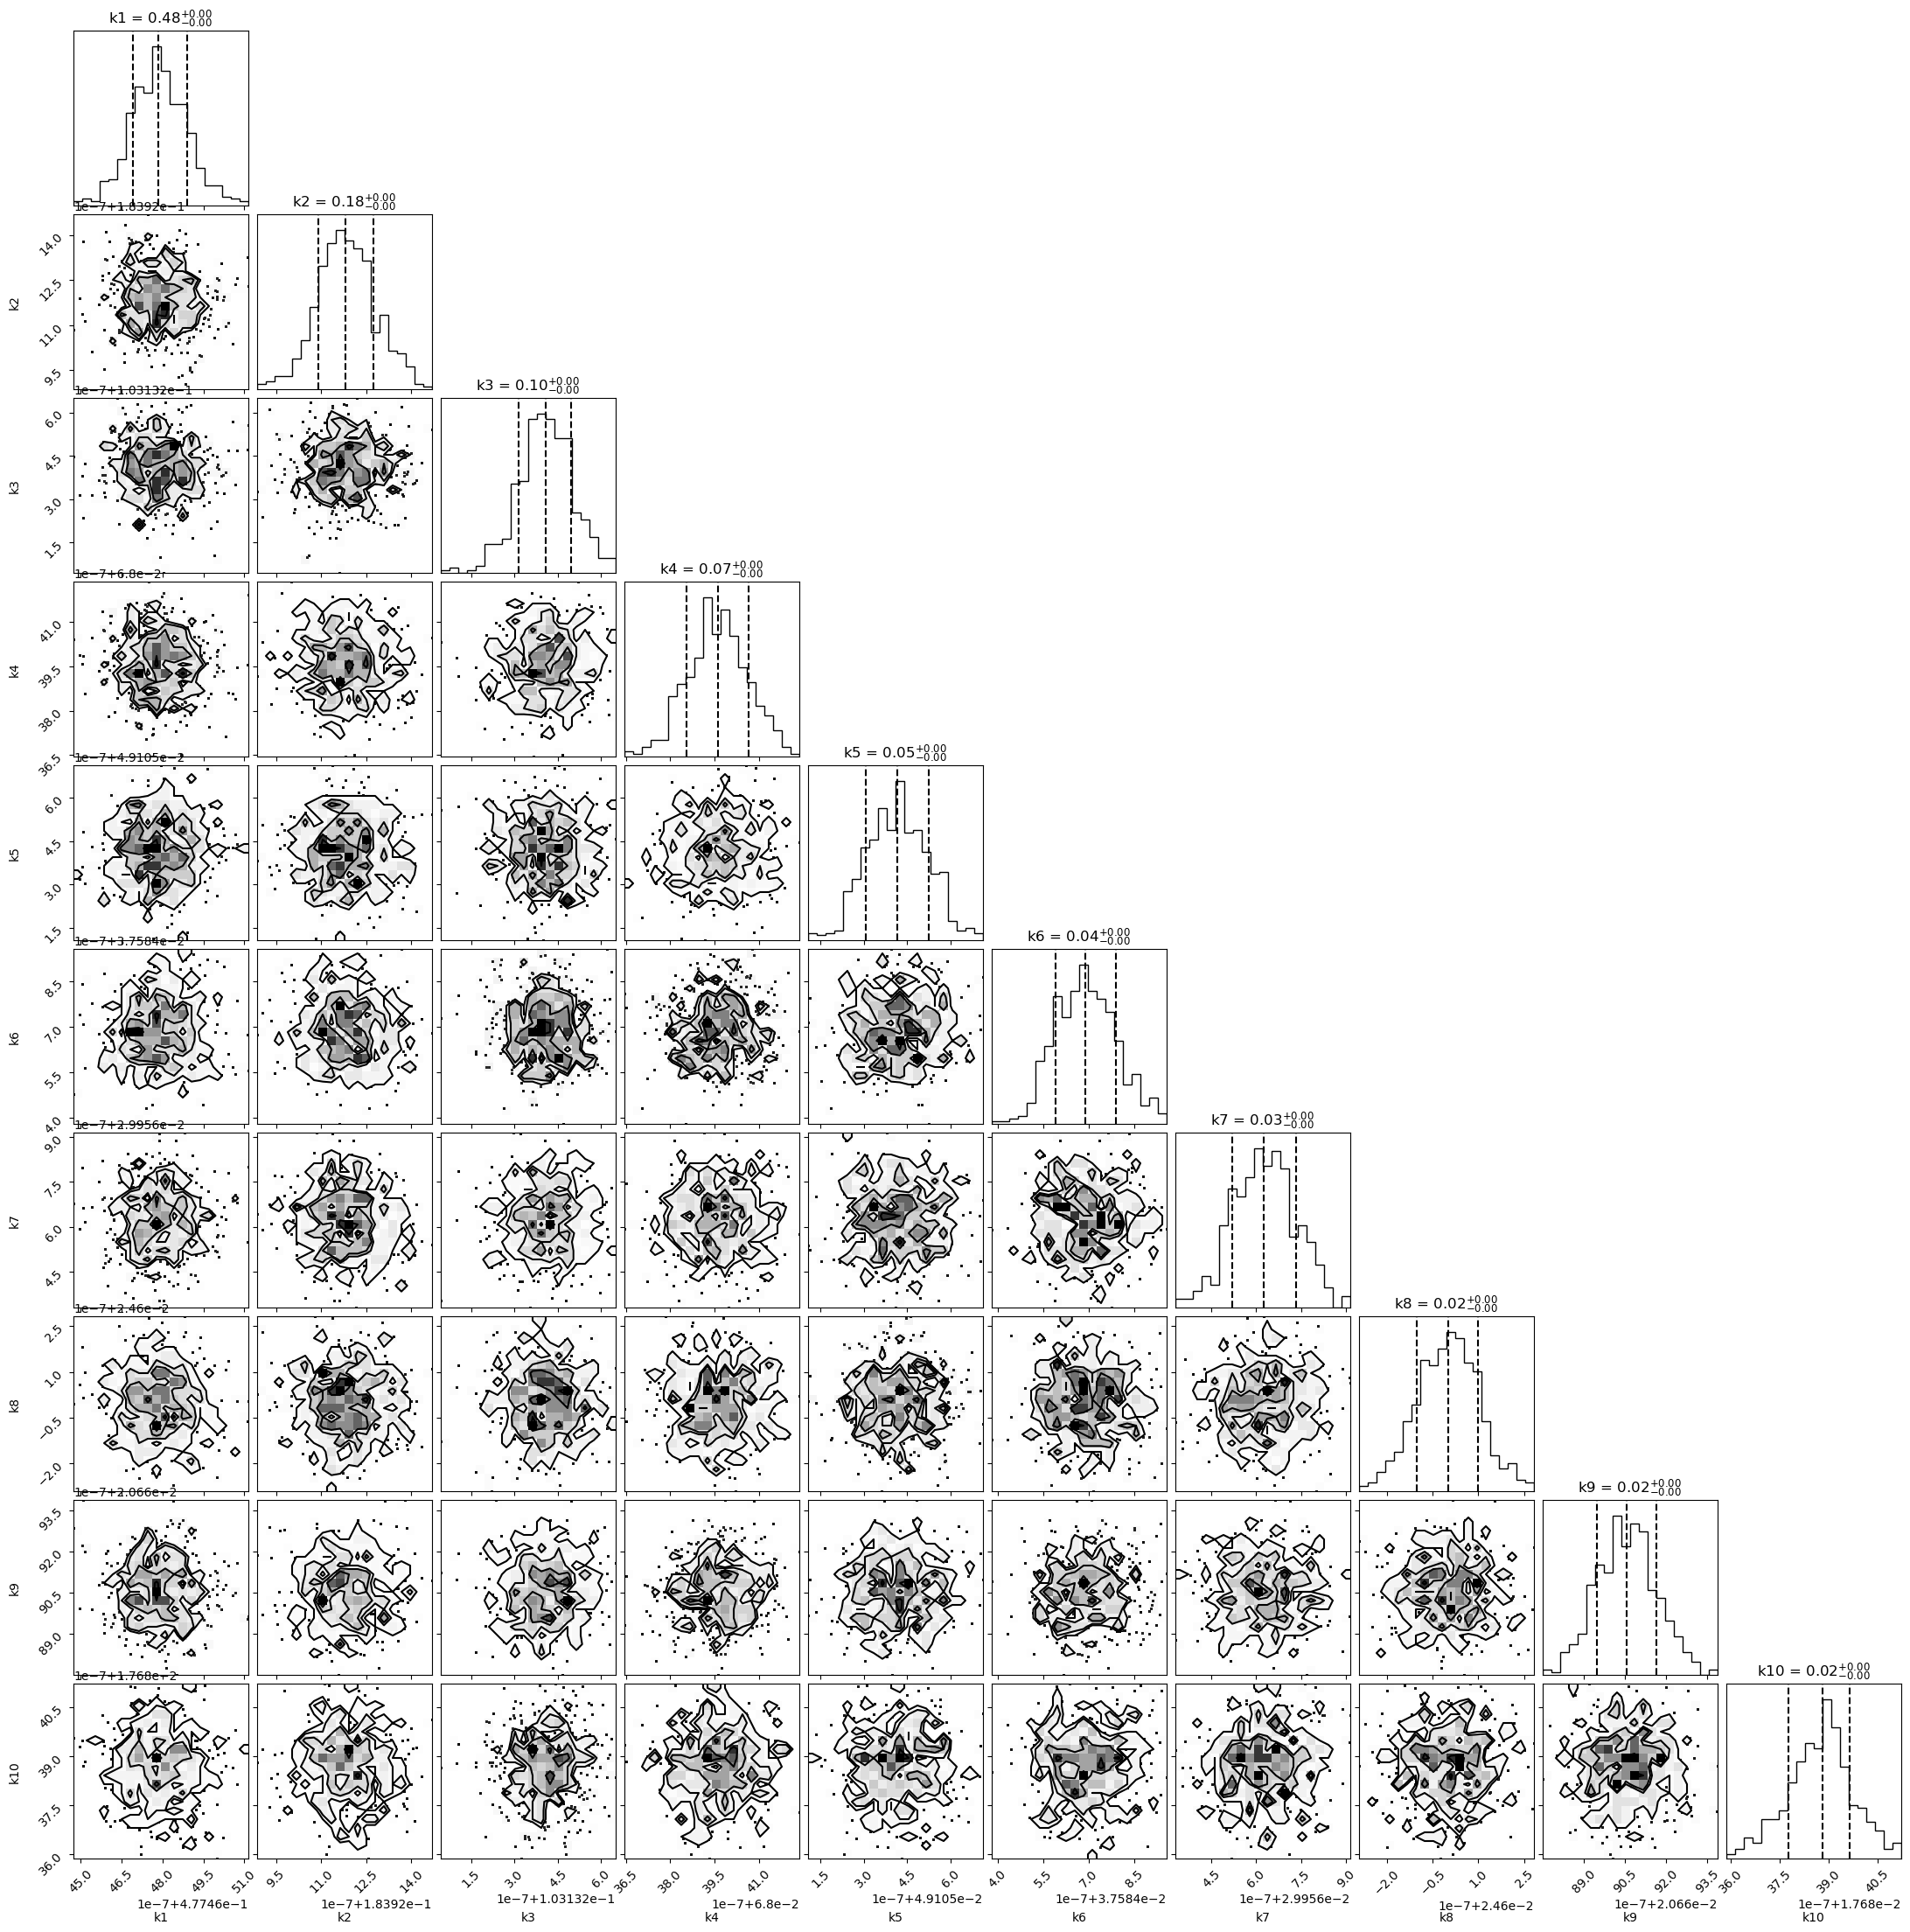

In [14]:

labels = []
for i in range(0, KNOTS):
    labels.append('k'+str(i+1))
mc_model.show_corner_plot(labels)

Text(0.5, 1.0, 'Target Disk')

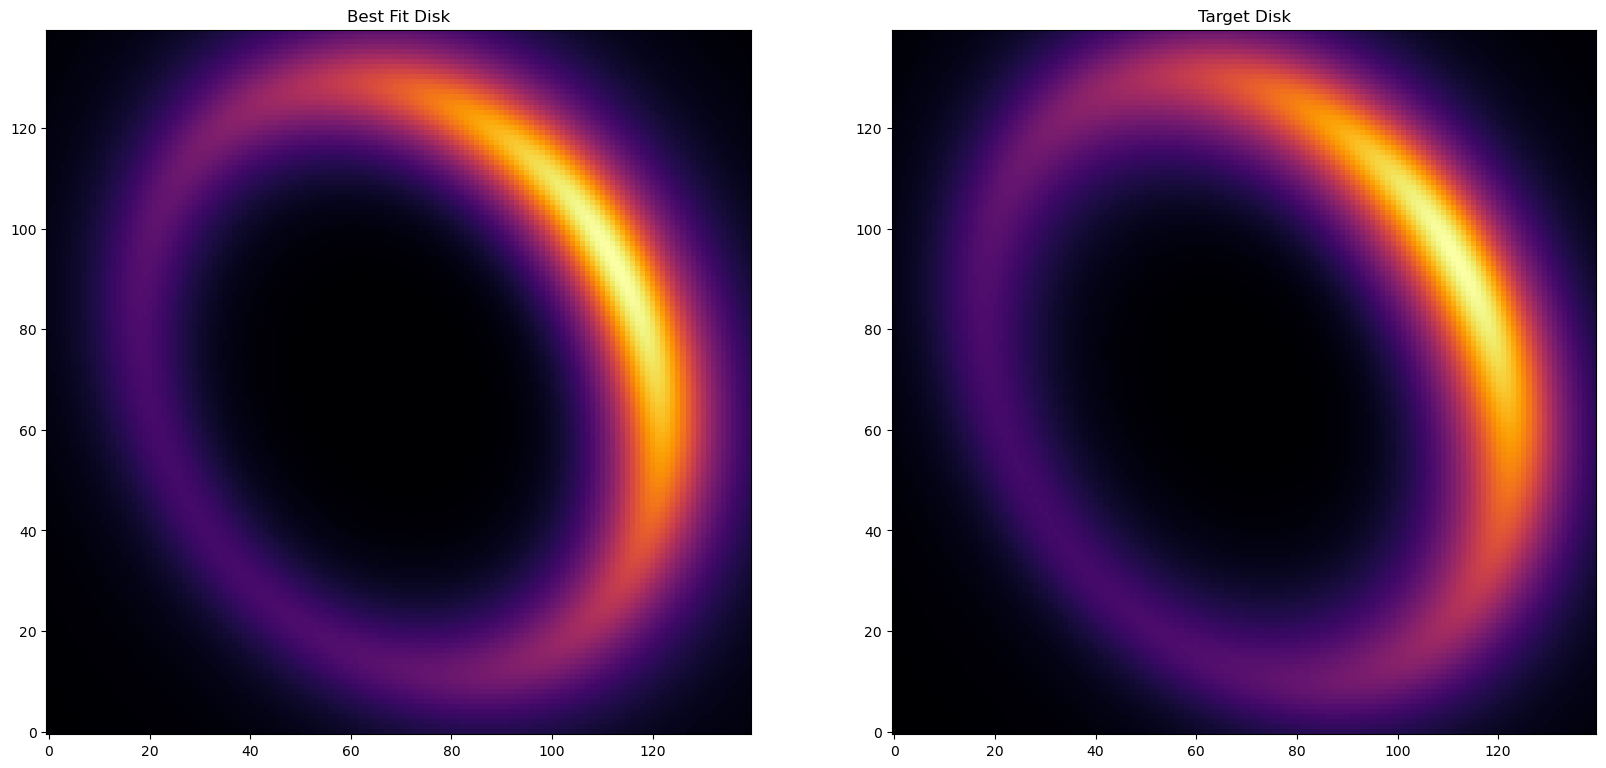

In [15]:
params = mc_model.get_theta_max()
best_fit_image = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, fitted_disk_params, InterpolatedUnivariateSpline_SPF.pack_pars(params), disk_params['flux_scaling'])

fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(best_fit_image, origin='lower', cmap='inferno')
axes[0].set_title("Best Fit Disk")

im = axes[1].imshow(disk_image, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk")

Text(0.5, 1.0, 'Target Image')

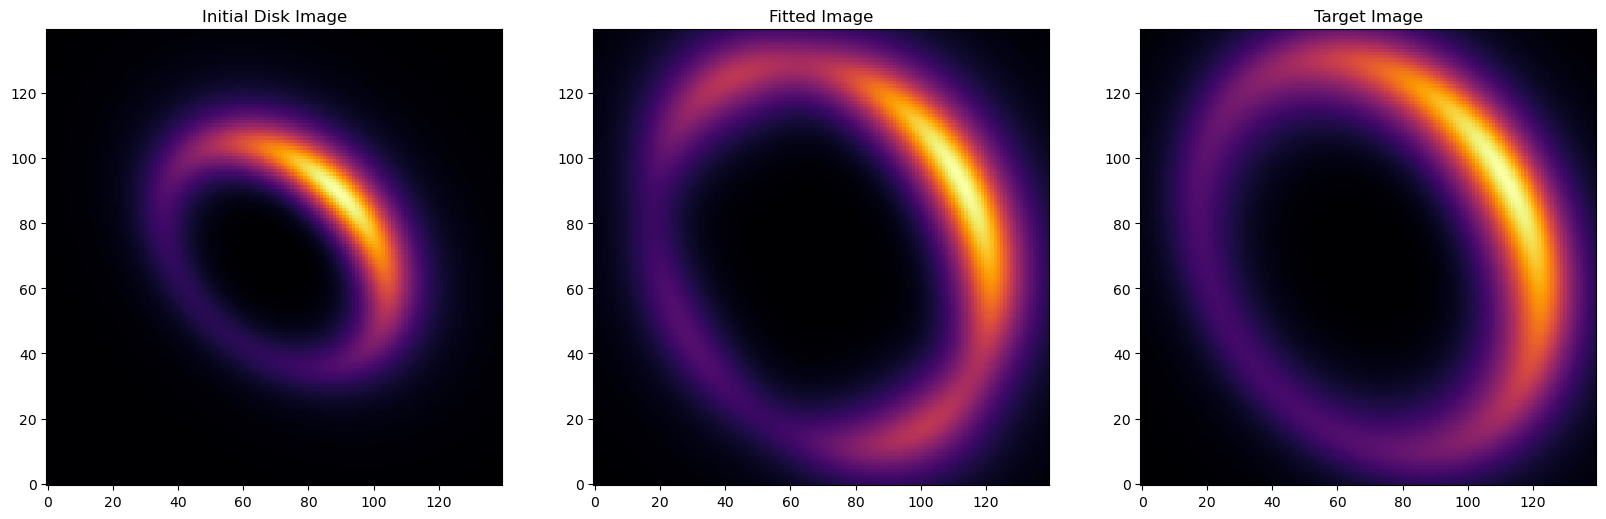

In [16]:
fitted_disk_image = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, soln_spline.x[0:5],
                                     InterpolatedUnivariateSpline_SPF.pack_pars(soln_spline.x[5:]), init_params["flux_scaling"])

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(init_image, origin='lower', cmap='inferno')
axes[0].set_title("Initial Disk Image")

im = axes[1].imshow(fitted_disk_image, origin='lower', cmap='inferno')
axes[1].set_title("Fitted Image")

im = axes[2].imshow(disk_image, origin='lower', cmap='inferno')
axes[2].set_title("Target Image")

Running burn-in...


/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Running production...
0:00:04.330397


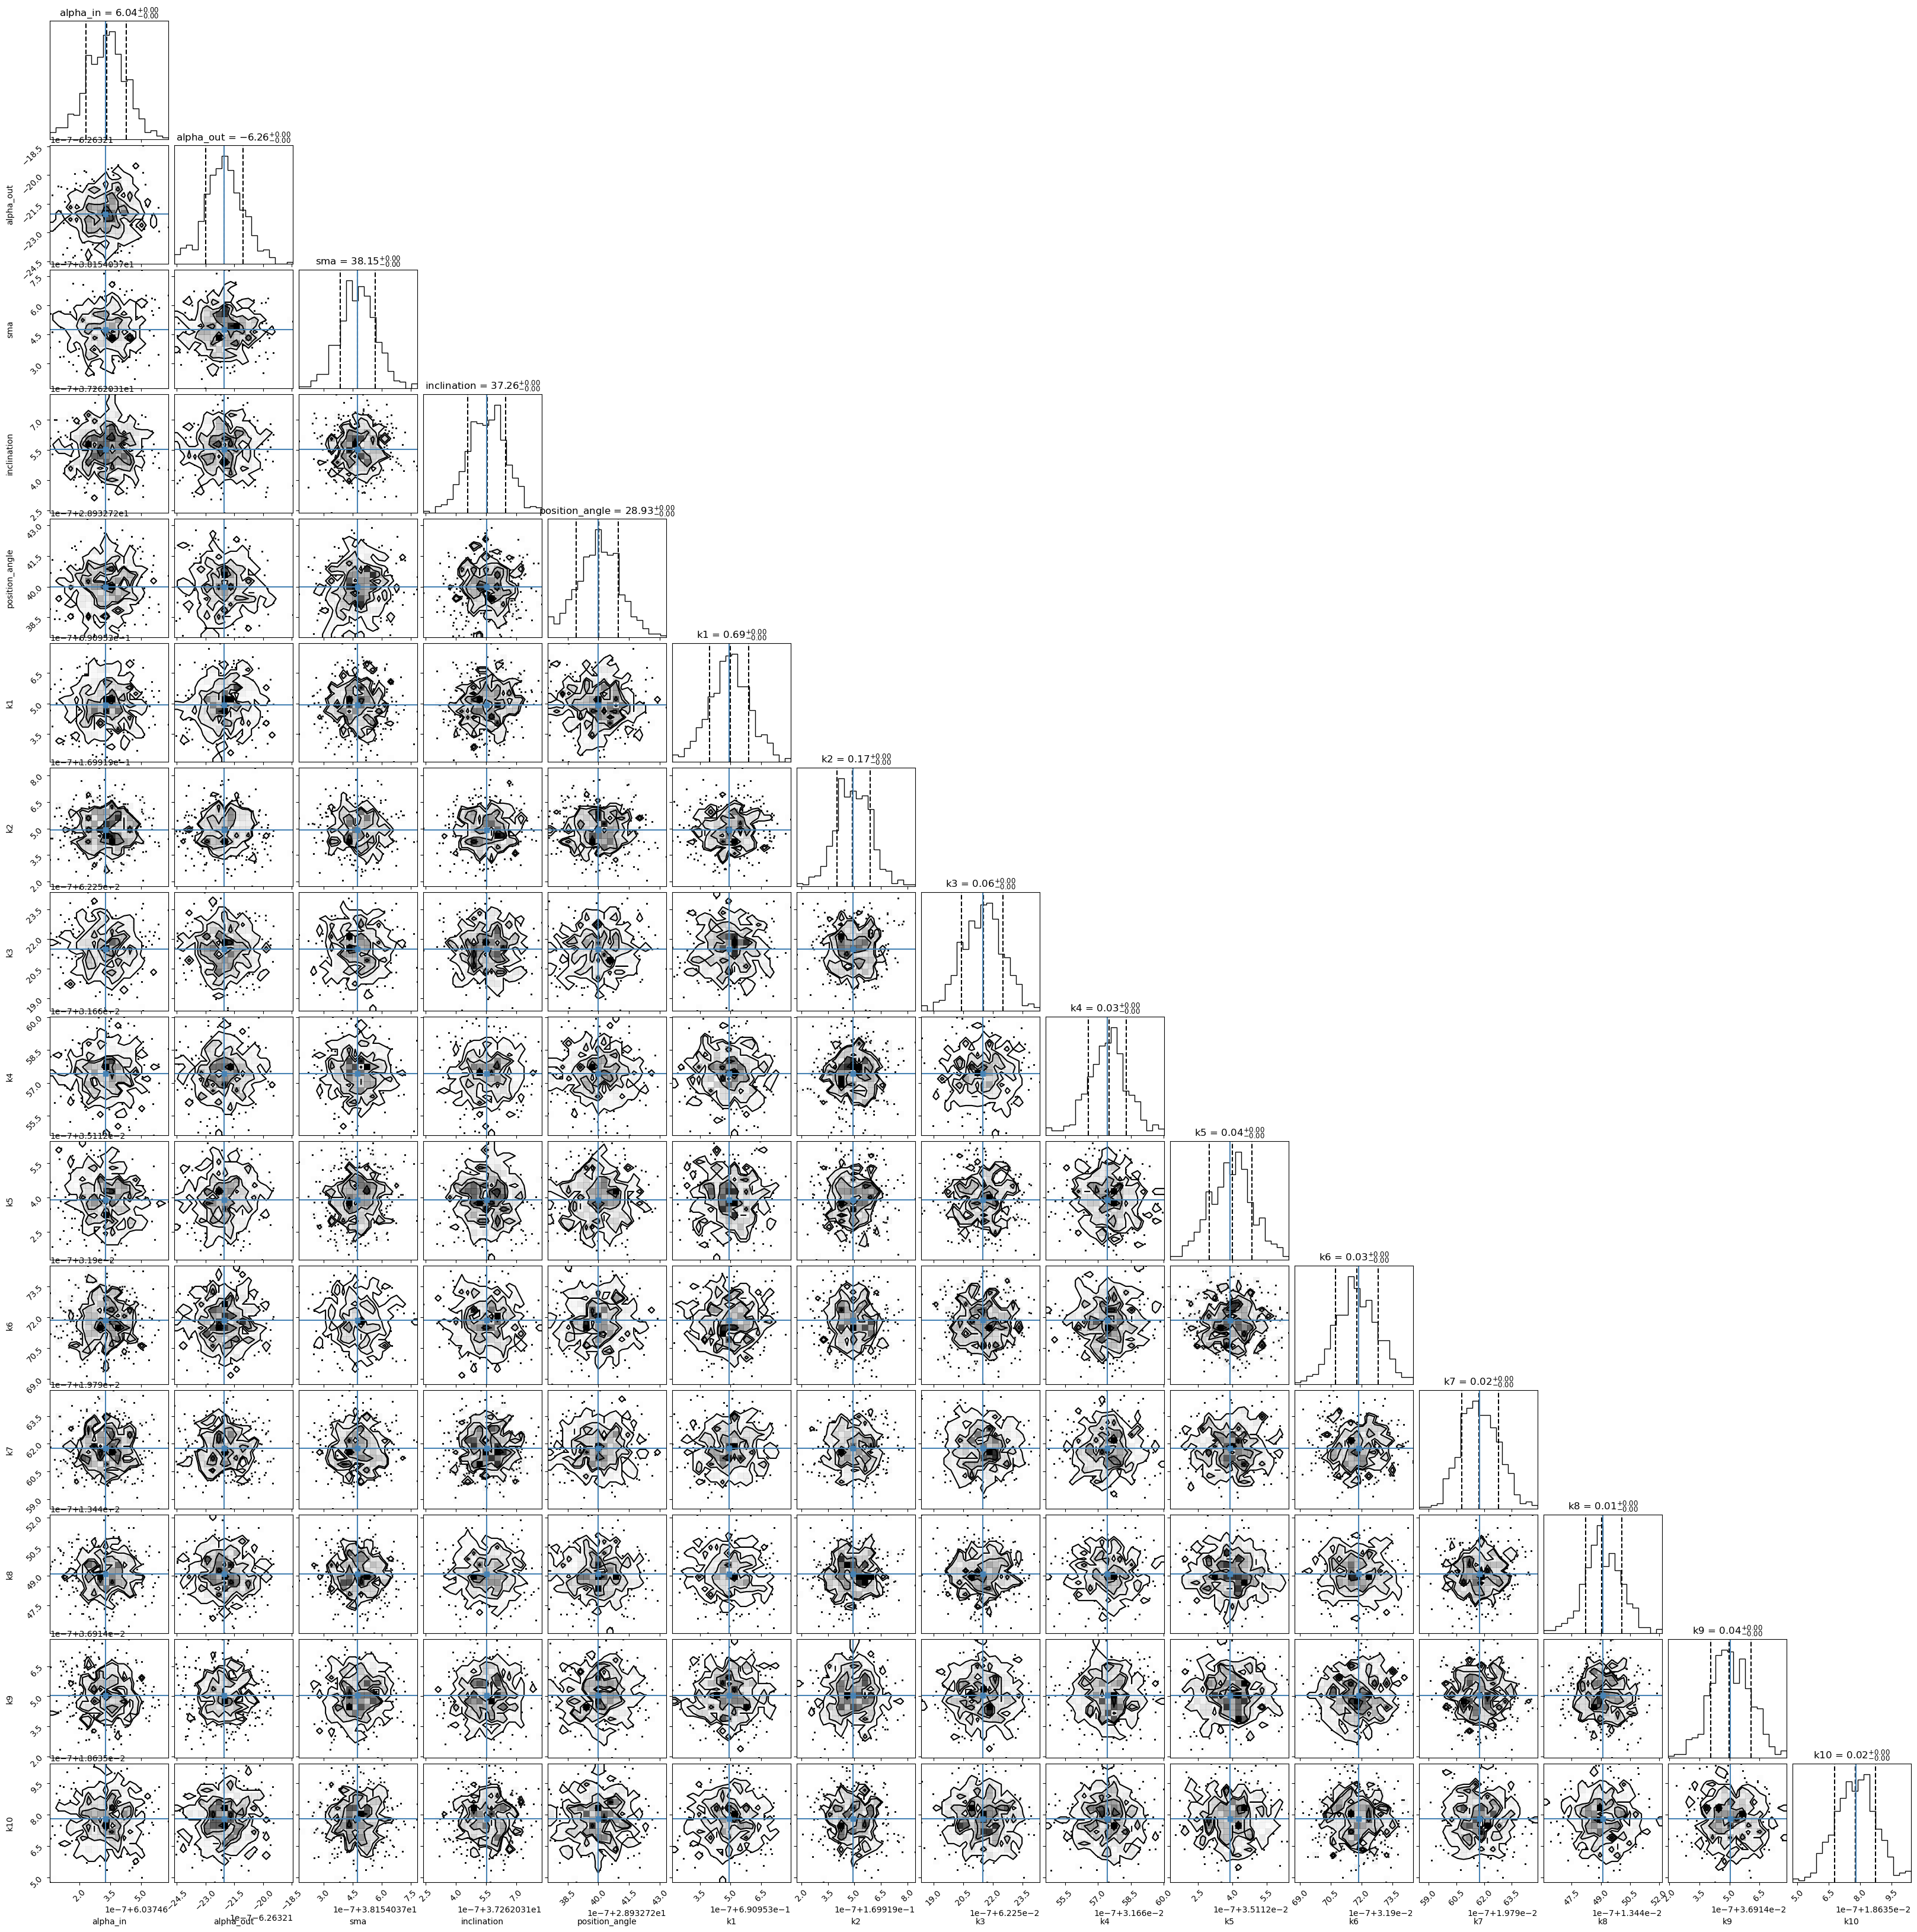

In [17]:
llap = lambda theta: -log_likelihood_1d_pos_spline(theta, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, init_params['flux_scaling'],
                                        target_image, err_map)

#init_disk_params = jnp.array([init_params['alpha_in'], init_params['alpha_out'], init_params['sma'], init_params['inclination'],
#                           init_params['position_angle']])

DISK_BOUNDS = np.array([np.array([1, -10, 10, 0, 0]), np.array([10, -1, 80, 180, 180])])
SPLINE_BOUNDS = np.array([np.zeros(KNOTS), np.ones(KNOTS)])
BOUNDS = np.array([np.concatenate([DISK_BOUNDS[0], SPLINE_BOUNDS[0]]), np.concatenate([DISK_BOUNDS[1], SPLINE_BOUNDS[1]])])

start = datetime.now()
mc_model = MCMC_model(llap, BOUNDS)
mc_model.run(soln_spline.x, niter = 1000, nconst = 1e-7)
labels = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle']
for i in range(0, KNOTS):
    labels.append('k'+str(i+1))
mc_model.show_corner_plot(labels, truths=soln_spline.x)
end = datetime.now()
print(end-start)

[ 6.03746006e+00 -6.26321225e+00  3.81540374e+01  3.72620316e+01
  2.89327239e+01  6.90953467e-01  1.69919325e-01  6.22521687e-02
  3.16657488e-02  3.51123503e-02  3.19073189e-02  1.97962217e-02
  1.34449359e-02  3.69144266e-02  1.86354765e-02]


Text(0.5, 1.0, 'Target Disk')

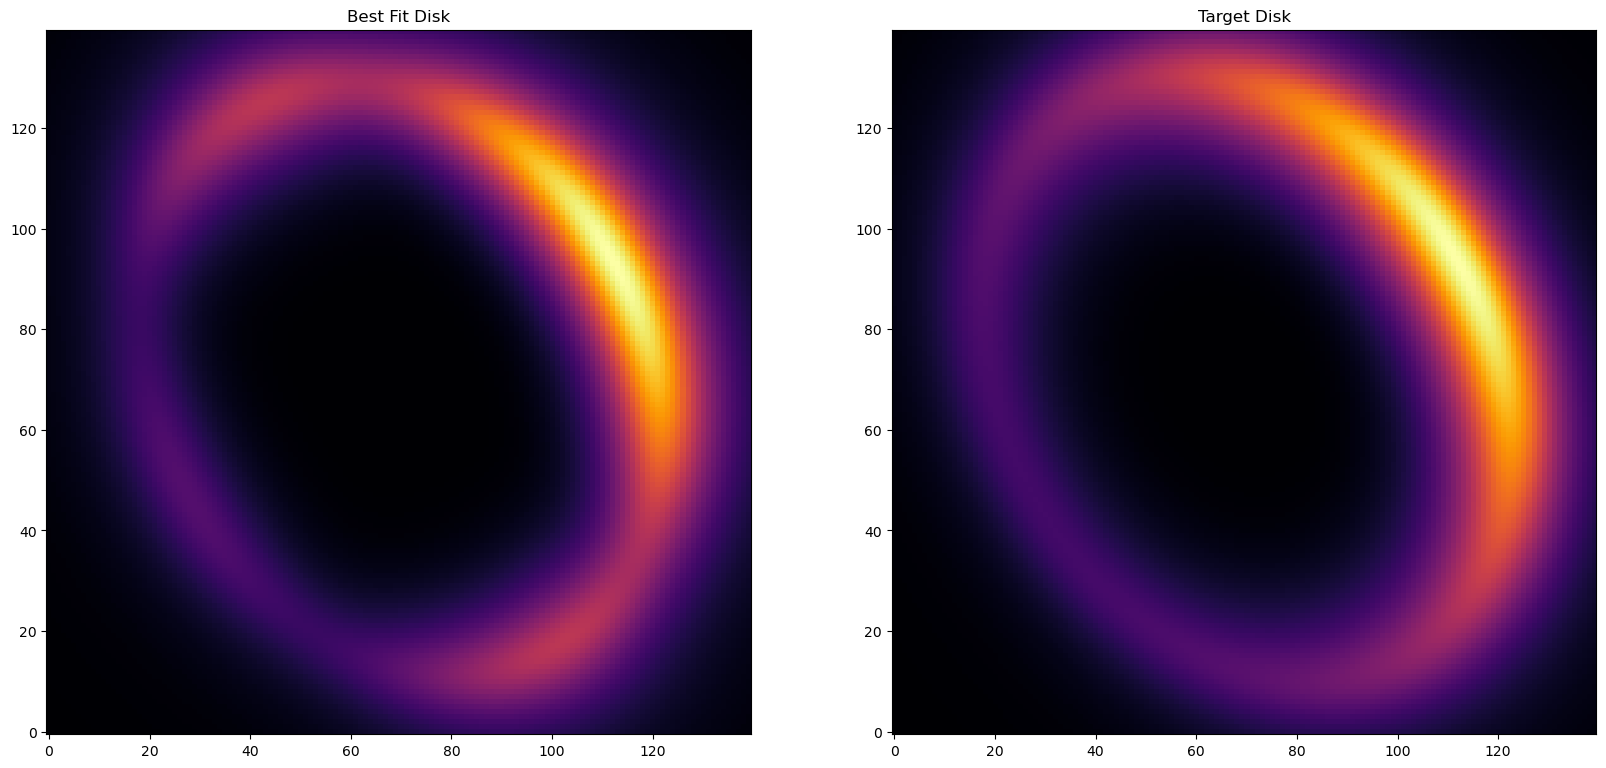

In [18]:
params = mc_model.get_theta_max()
print(params)
best_fit_image = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, params[0:5], InterpolatedUnivariateSpline_SPF.pack_pars(params[5:]), disk_params['flux_scaling'])

fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(best_fit_image, origin='lower', cmap='inferno')
axes[0].set_title("Best Fit Disk")

im = axes[1].imshow(disk_image, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk")